In [1]:
from collections import defaultdict, OrderedDict
from copy import deepcopy

import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt

import simuPOP as sp
from simuPOP import demography
%matplotlib inline

simuPOP Version 1.1.8.3 : Copyright (c) 2004-2016 Bo Peng
Revision 4553 (Feb 11 2017) for Python 3.6.0 (64bit, 1thread)
Random Number Generator is set to mt19937 with random seed 0xc24986d81eba069a.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


In [2]:
num_loci = 10
pop_size = 50
num_gens = 101
num_pops = 10
migs = [0, 0.005, 0.01, 0.02, 0.05, 0.1]

In [3]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

In [4]:
def init_accumulators(pop, param):
    accumulators = param
    for accumulator in accumulators:
        if accumulator.endswith('_sp'):
            pop.vars()[accumulator] = defaultdict(list)
        else:
            pop.vars()[accumulator] = []
    return True

def update_accumulator(pop, param):
    accumulator, var = param
    if  var.endswith('_sp'):
        for sp in range(pop.numSubPop()):
            pop.vars()[accumulator][sp].append(deepcopy(pop.vars(sp)[var[:-3]]))
    else:
        pop.vars()[accumulator].append(deepcopy(pop.vars()[var]))
    return True

In [5]:
pops = sp.Population([pop_size] * num_pops, loci=[1] * num_loci, infoFields=['migrate_to'])

In [6]:
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['fst'])
init_ops['Sex'] = sp.InitSex()
init_ops['Freq'] = sp.InitGenotype(freq=[0.5, 0.5])
for i, mig in enumerate(migs):
    post_ops['mig-%d' % i] = sp.Migrator(demography.migrIslandRates(mig, num_pops), reps=[i])
post_ops['Stat-fst'] = sp.Stat(structure=sp.ALL_AVAIL)
post_ops['fst_accumulation'] = sp.PyOperator(update_accumulator, param=('fst', 'F_st'))

In [7]:
mating_scheme = sp.RandomMating()

In [8]:
sim = sp.Simulator(pops, rep=len(migs))
sim.evolve(initOps=list(init_ops.values()), preOps=list(pre_ops.values()), postOps=list(post_ops.values()),
           matingScheme=mating_scheme, gen=num_gens)

(101, 101, 101, 101, 101, 101)

Text(0.5,0,'Generation')

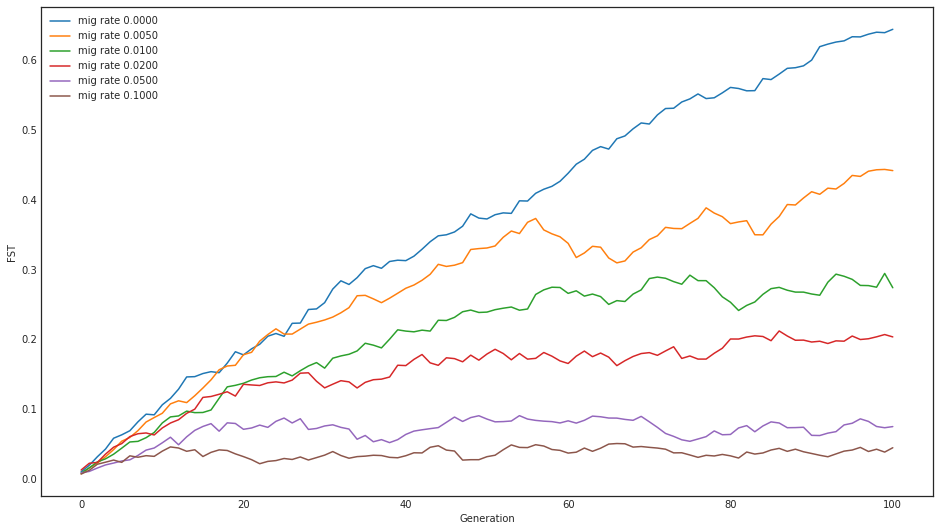

In [9]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
for i, pop in enumerate(sim.populations()):
    ax.plot(pop.dvars().fst, label='mig rate %.4f' % migs[i])
ax.legend(loc=2)
ax.set_ylabel('FST')
ax.set_xlabel('Generation')

In [10]:
num_gens = 400
num_loci = 5
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()
init_ops['Sex'] = sp.InitSex()
init_ops['Freq'] = sp.InitGenotype(freq=[0.5, 0.5])
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL, vars=['alleleFreq', 'alleleFreq_sp'])
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['allele_freq', 'allele_freq_sp'])
post_ops['freq_accumulation'] = sp.PyOperator(update_accumulator, param=('allele_freq', 'alleleFreq'))
post_ops['freq_sp_accumulation'] = sp.PyOperator(update_accumulator,
                                                 param=('allele_freq_sp', 'alleleFreq_sp'))

In [11]:
for i, mig in enumerate(migs):
    post_ops['mig-%d' % i] = sp.Migrator(demography.migrSteppingStoneRates(mig, num_pops), reps=[i])
#two 2 - talk
pops = sp.Population([pop_size] * num_pops, loci=[1] * num_loci, infoFields=['migrate_to'])

In [12]:
sim = sp.Simulator(pops, rep=len(migs))
sim.evolve(initOps=list(init_ops.values()), preOps=list(pre_ops.values()), postOps=list(post_ops.values()),
           matingScheme=mating_scheme, gen=num_gens)

(400, 400, 400, 400, 400, 400)

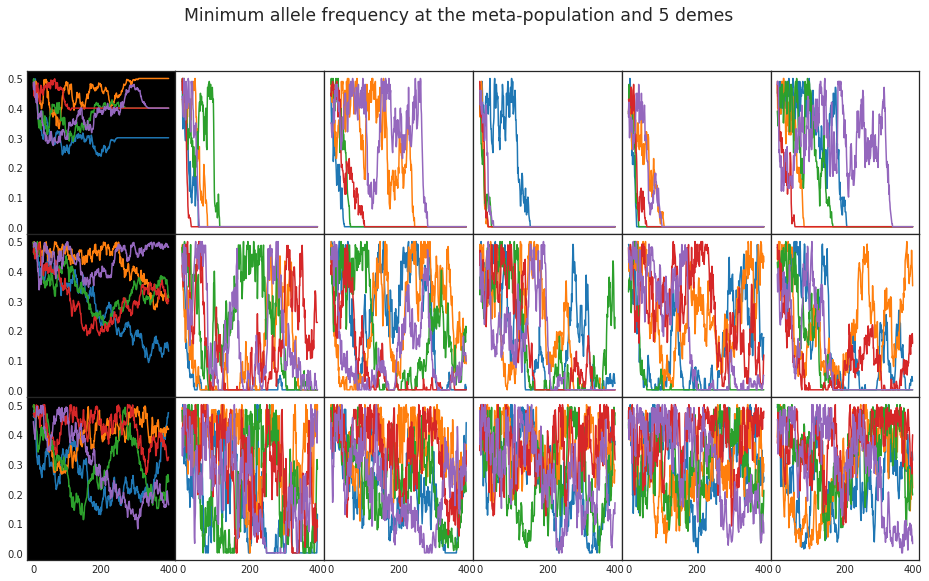

In [14]:
def get_maf(var):
    locus_data = [gen[locus] for gen in var]
    maf = [min(freq.values()) for freq in locus_data]
    maf = [v if v != 1 else 0 for v in maf]
    return maf
    
fig, axs = plt.subplots(3, num_pops // 2 + 1, figsize=(16, 9), sharex=True, sharey=True, squeeze=False)
fig.suptitle('Minimum allele frequency at the meta-population and 5 demes', fontsize='xx-large')
for line, pop in enumerate([sim.population(0), sim.population(1), sim.population(len(migs) - 1)]):
    for locus in range(num_loci):
        maf = get_maf(pop.dvars().allele_freq)
        axs[line, 0].plot(maf)
        axs[line, 0].set_facecolor('black')
    for nsp in range(num_pops // 2):
        for locus in range(num_loci):
            maf = get_maf(pop.dvars().allele_freq_sp[nsp * 2])
            axs[line, nsp + 1].plot(maf)
fig.subplots_adjust(hspace=0, wspace=0)